## Differential expression

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2      

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5589, 3058)
(5589, 18752)
  (0, 1)	0.90436876
  (0, 6)	0.90436876
  (1, 6)	0.9678403
  (2, 6)	0.5124039


In [5]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### 1. T-test

ranking genes
    finished (0:00:05)


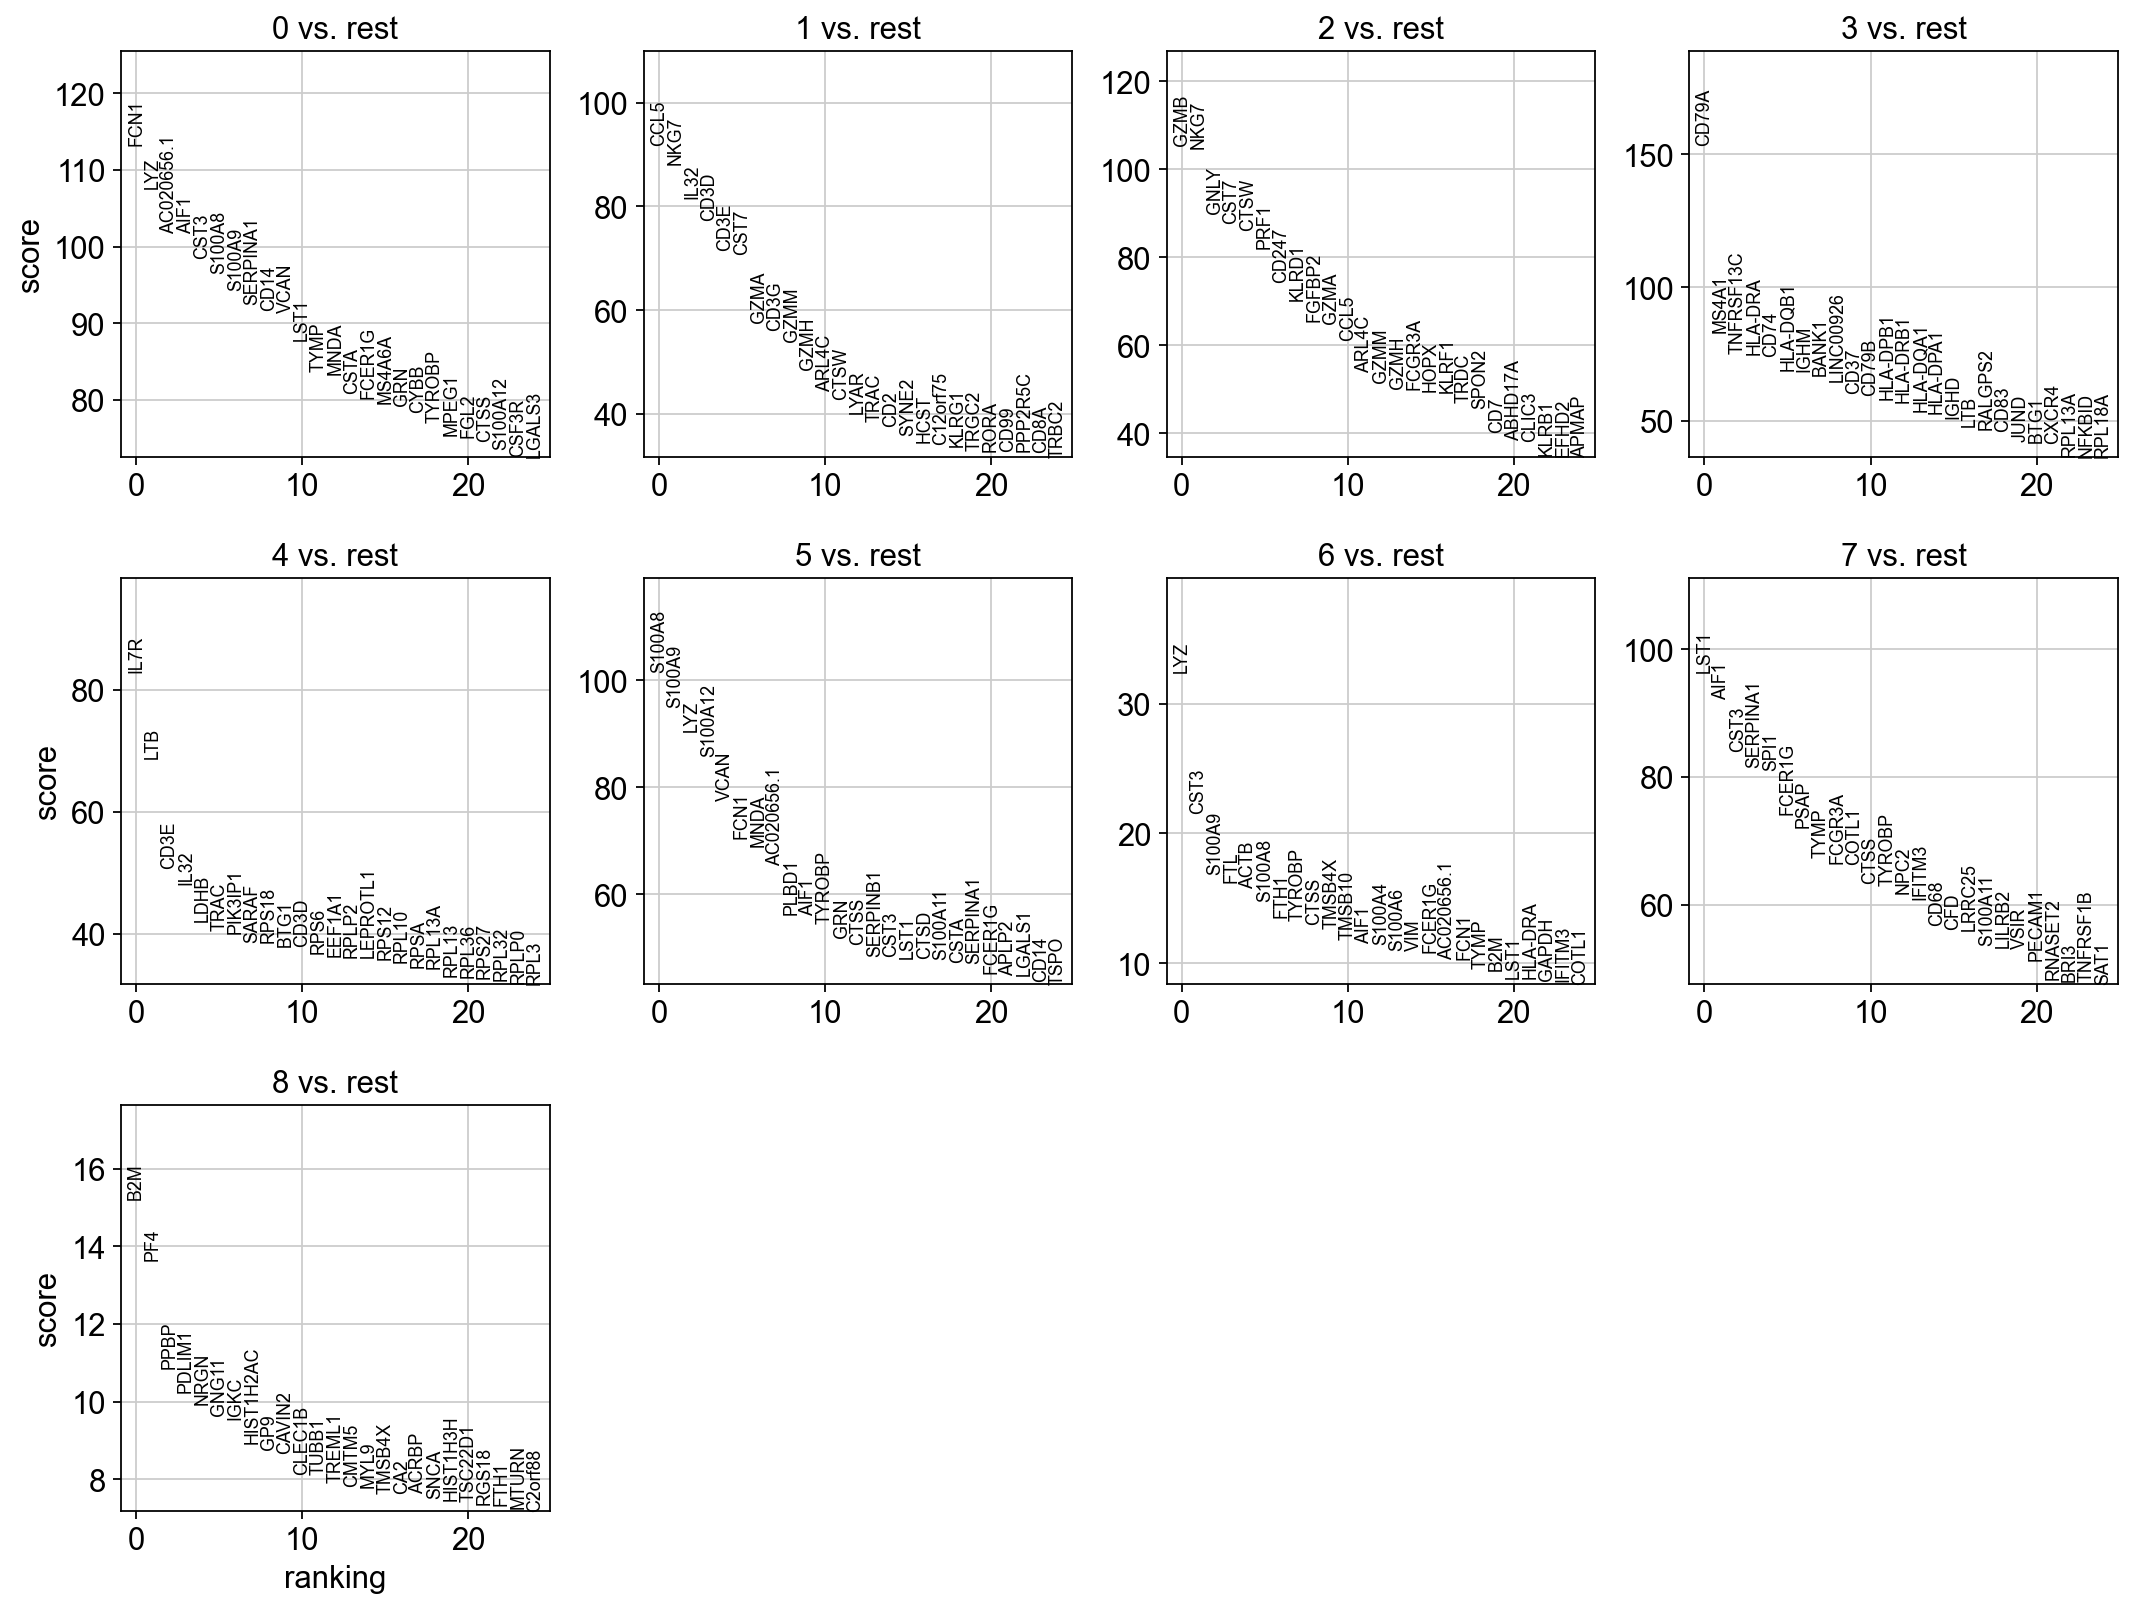

In [6]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

### 2. T-test overestimated_variance

ranking genes
    finished (0:00:02)


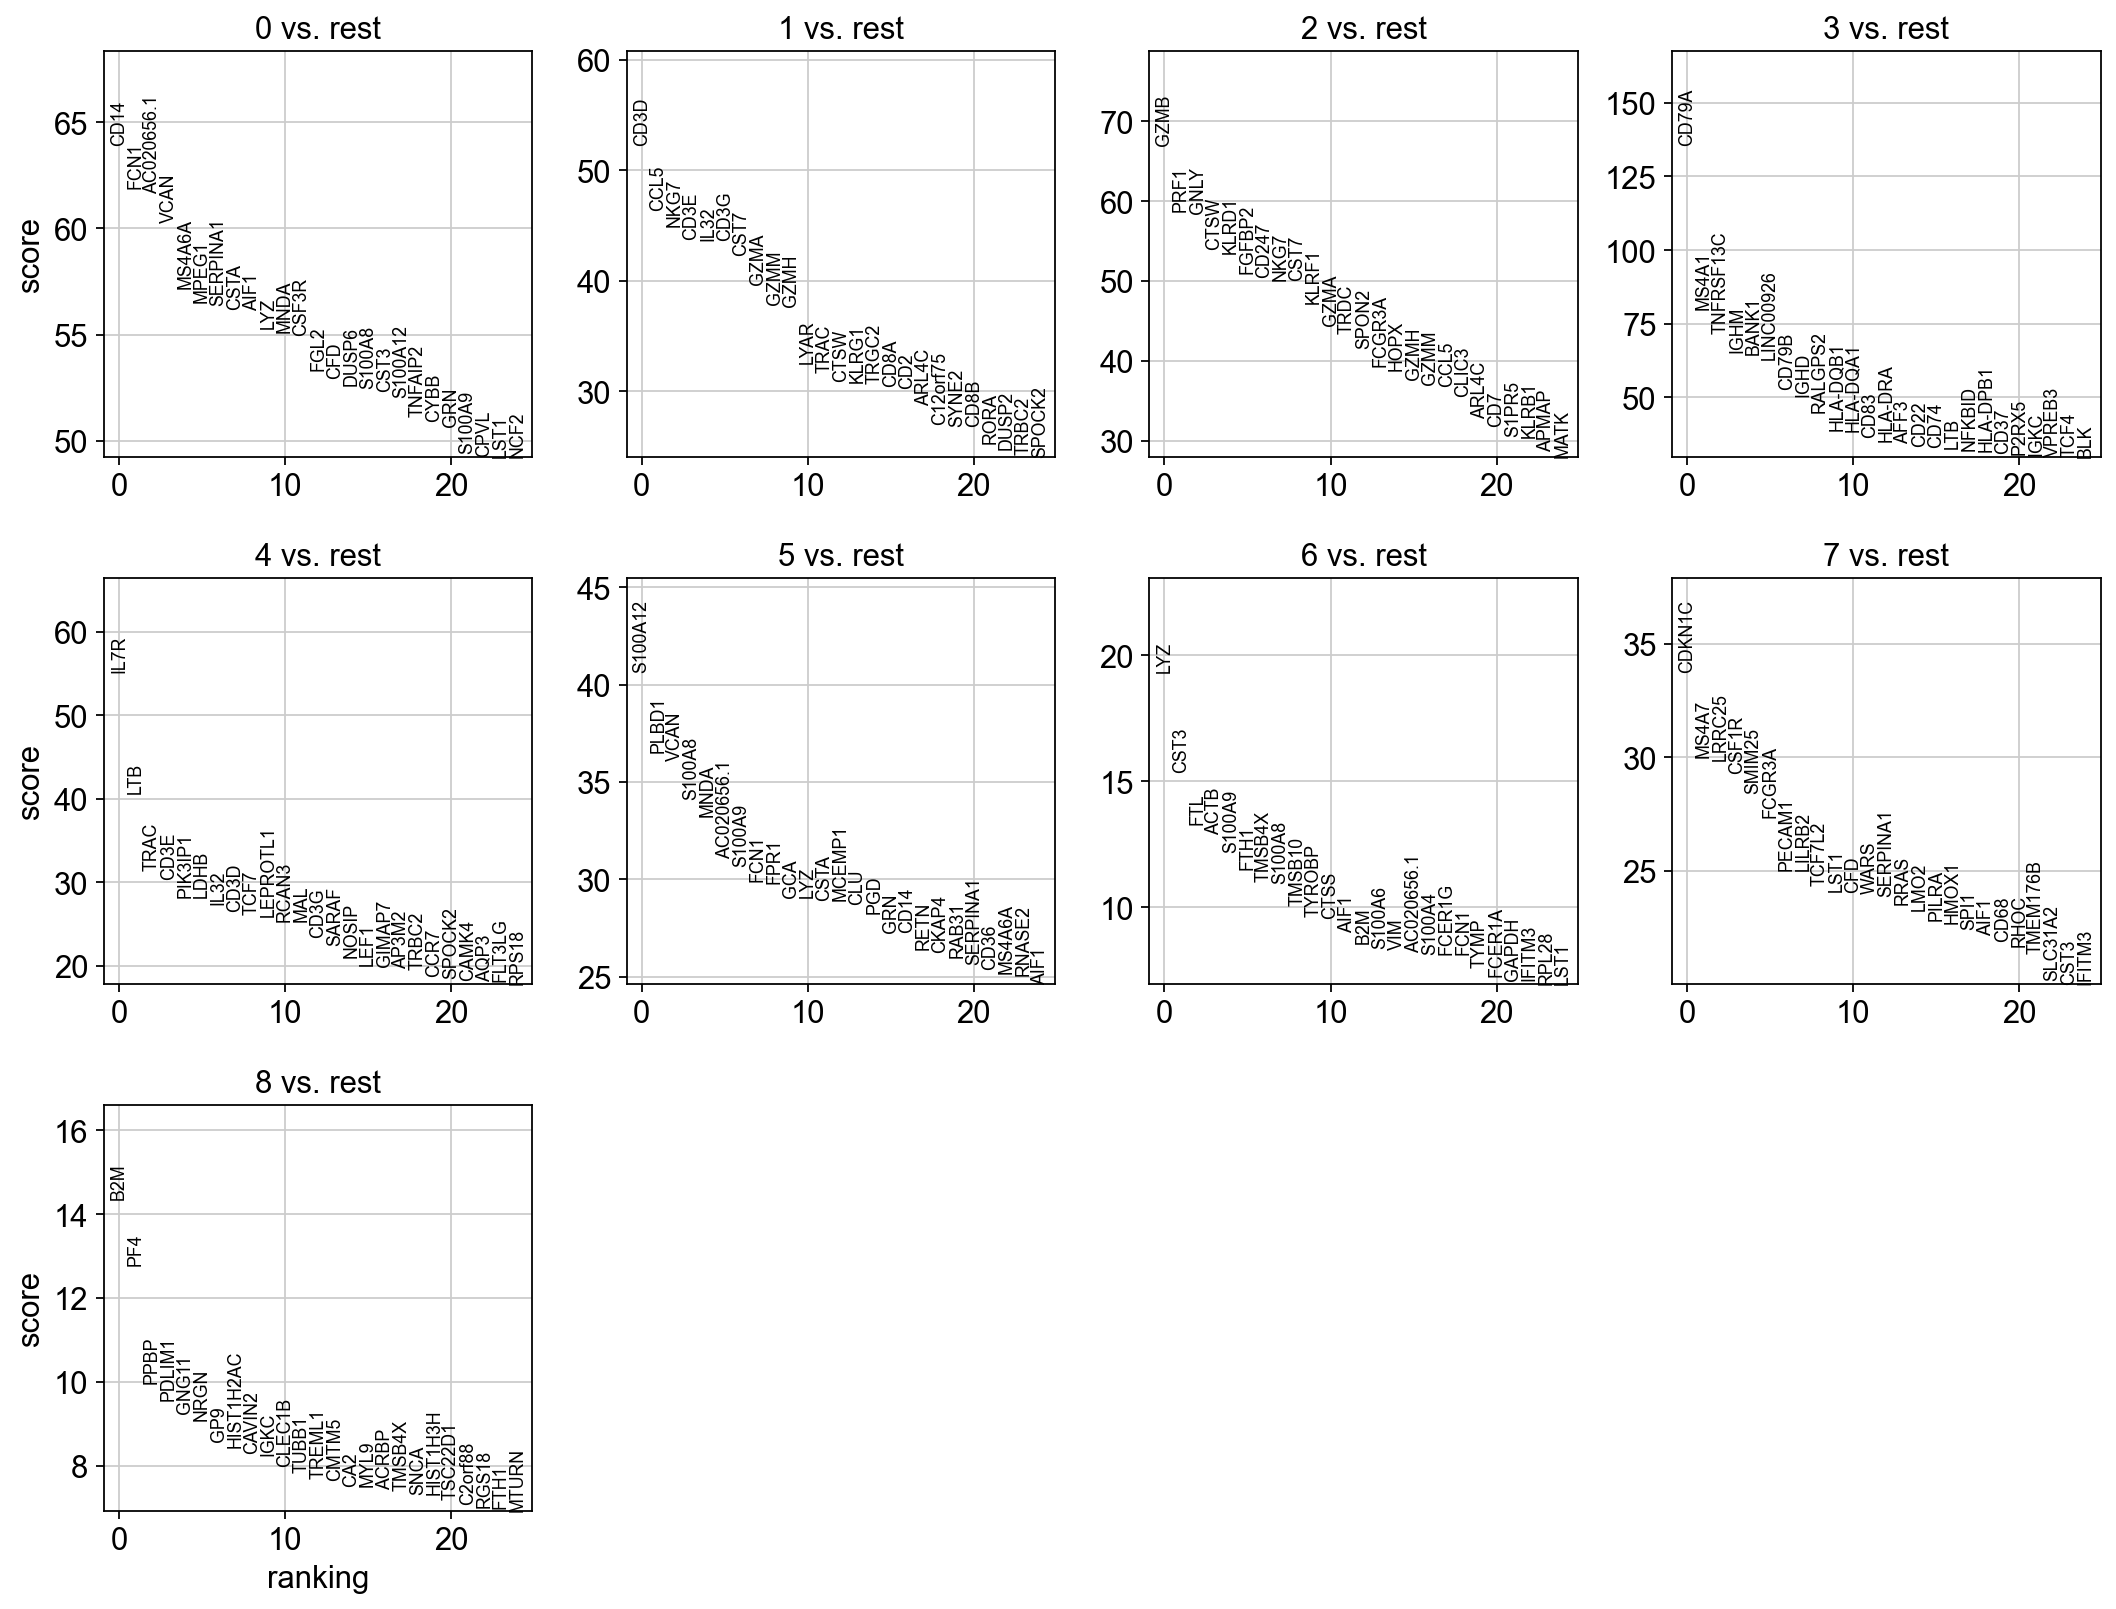

In [10]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key= "t-test_ov")

### 3. Wilcoxon rank-sum

ranking genes
    finished (0:00:25)


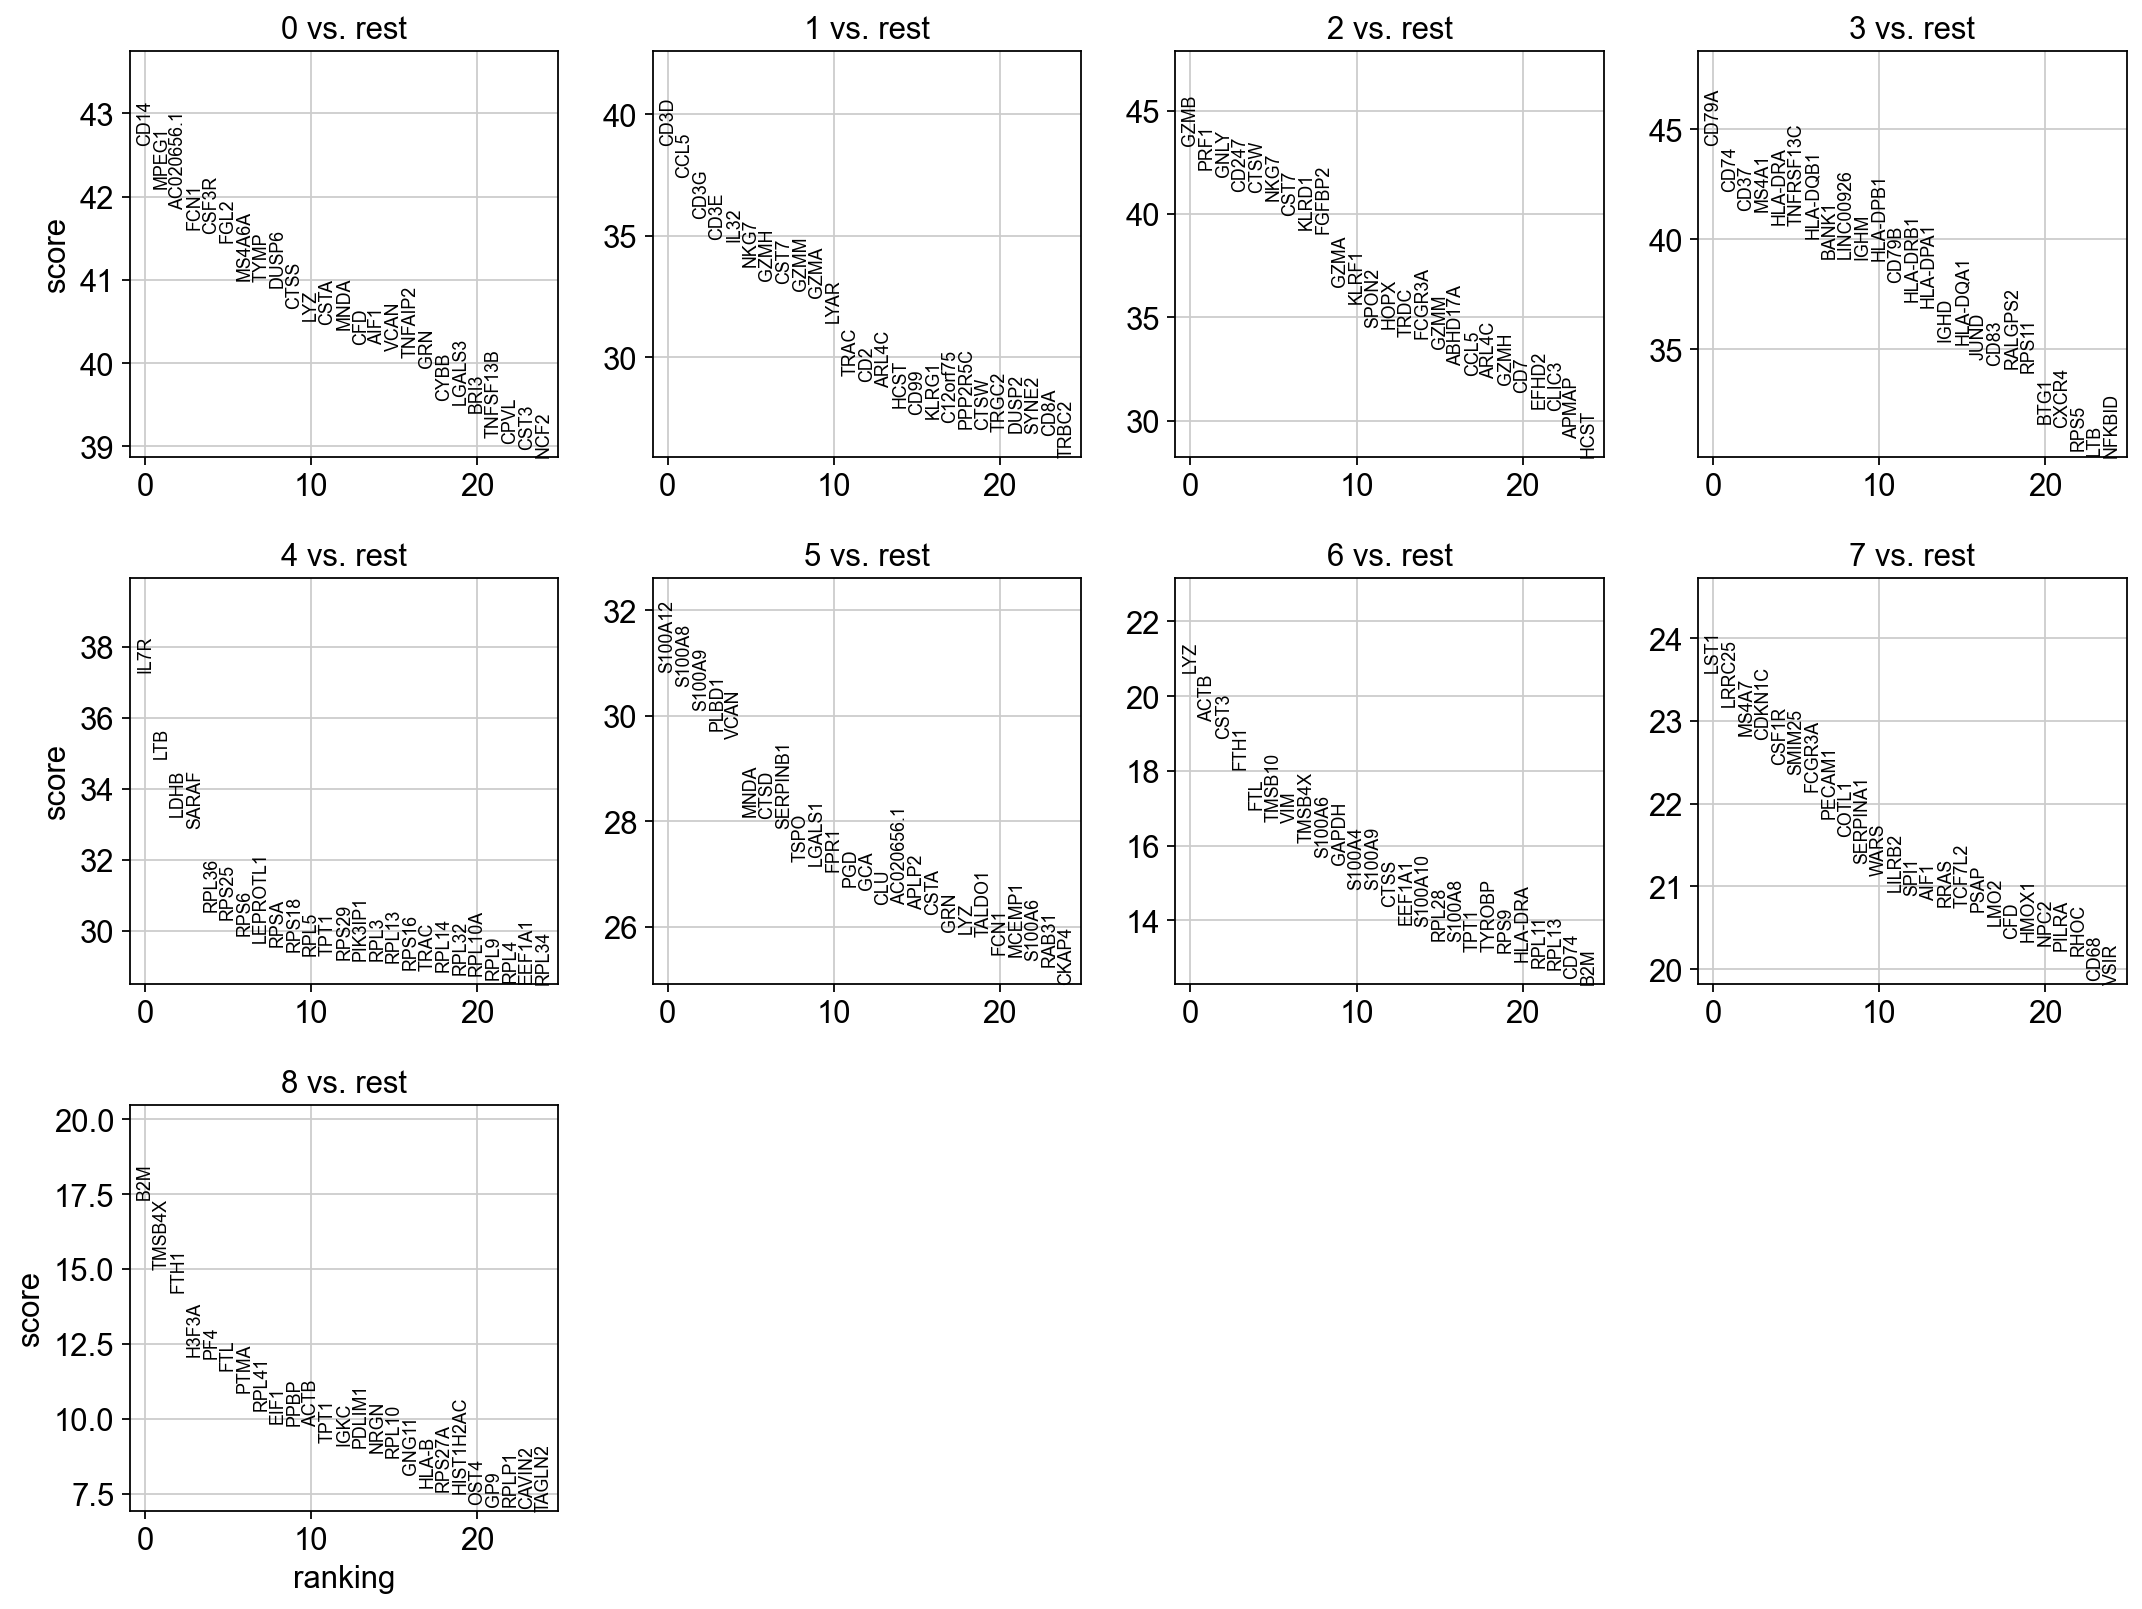

In [12]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### 4  Logistic regression test

ranking genes
    finished (0:00:46)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


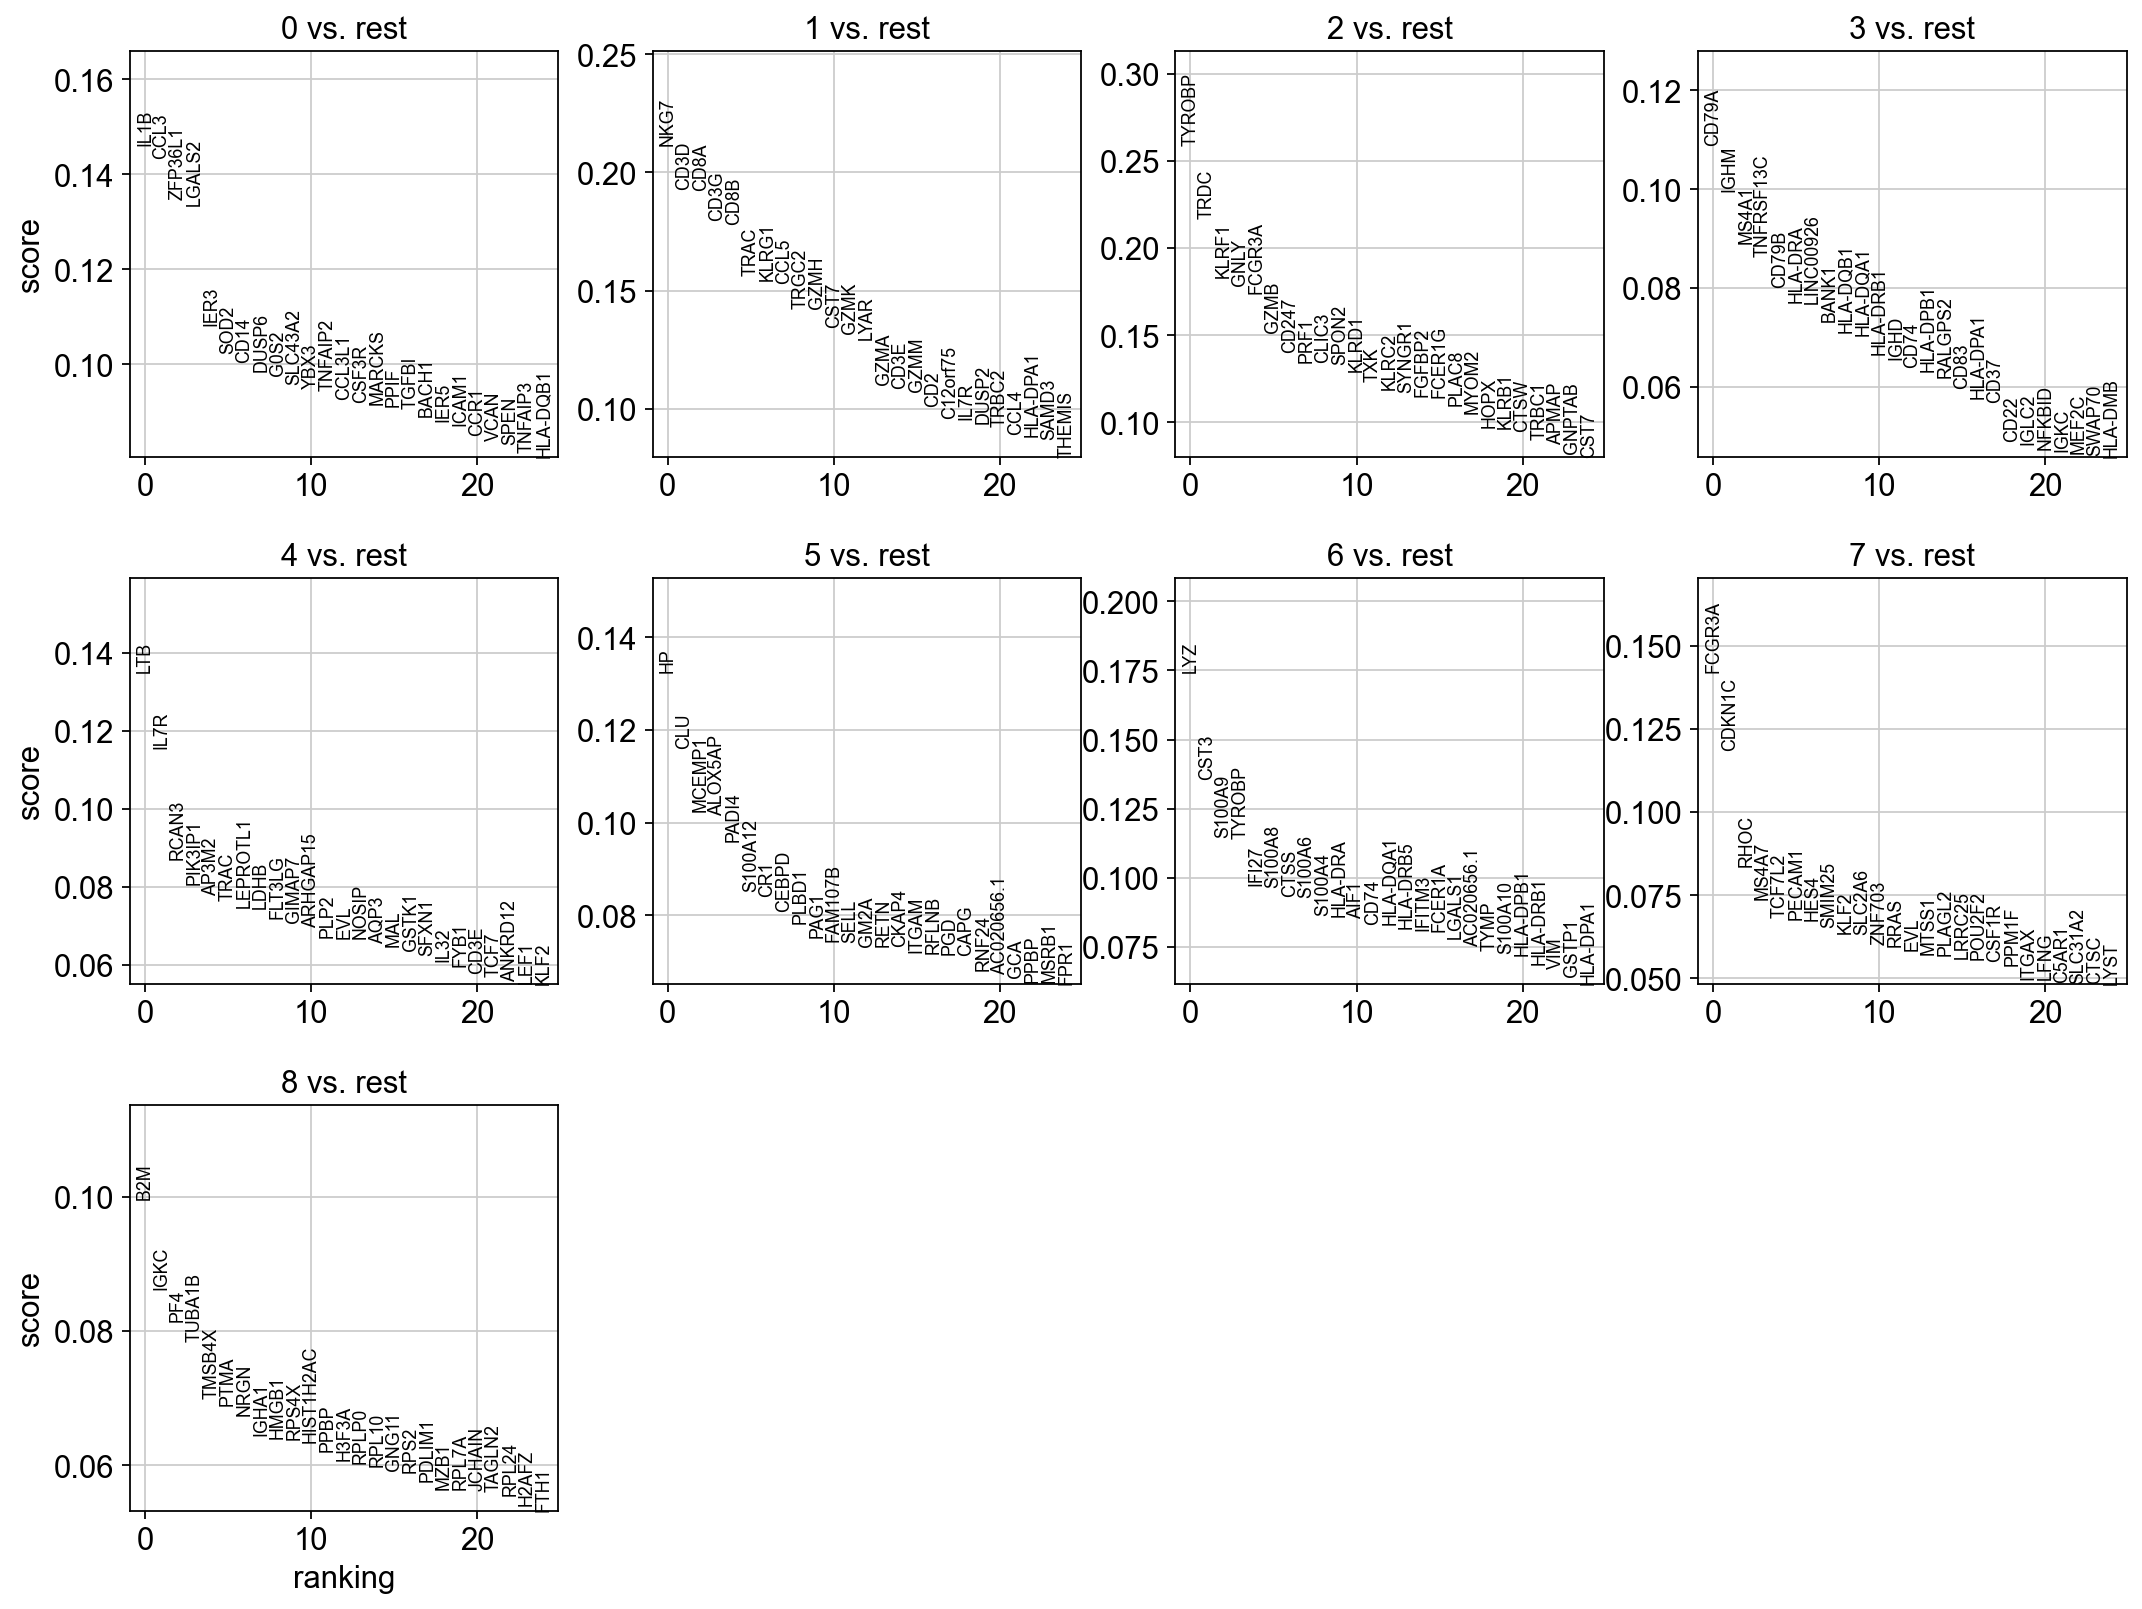

In [13]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### 5. Compare genes

compare DE gnes for cluster 0 with each test 

In [15]:
wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

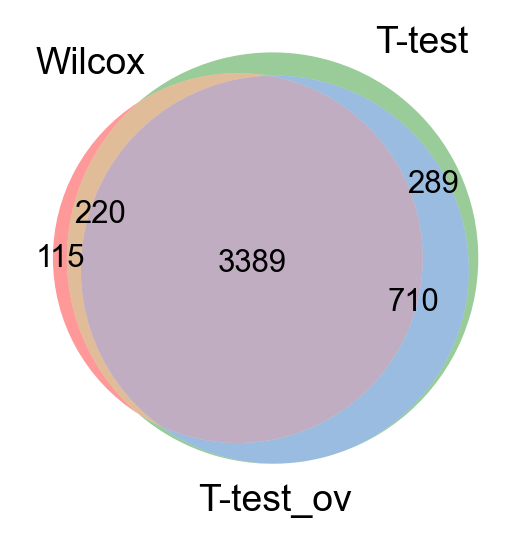

In [18]:
from matplotlib_venn import venn3
venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

### 6. Visualization

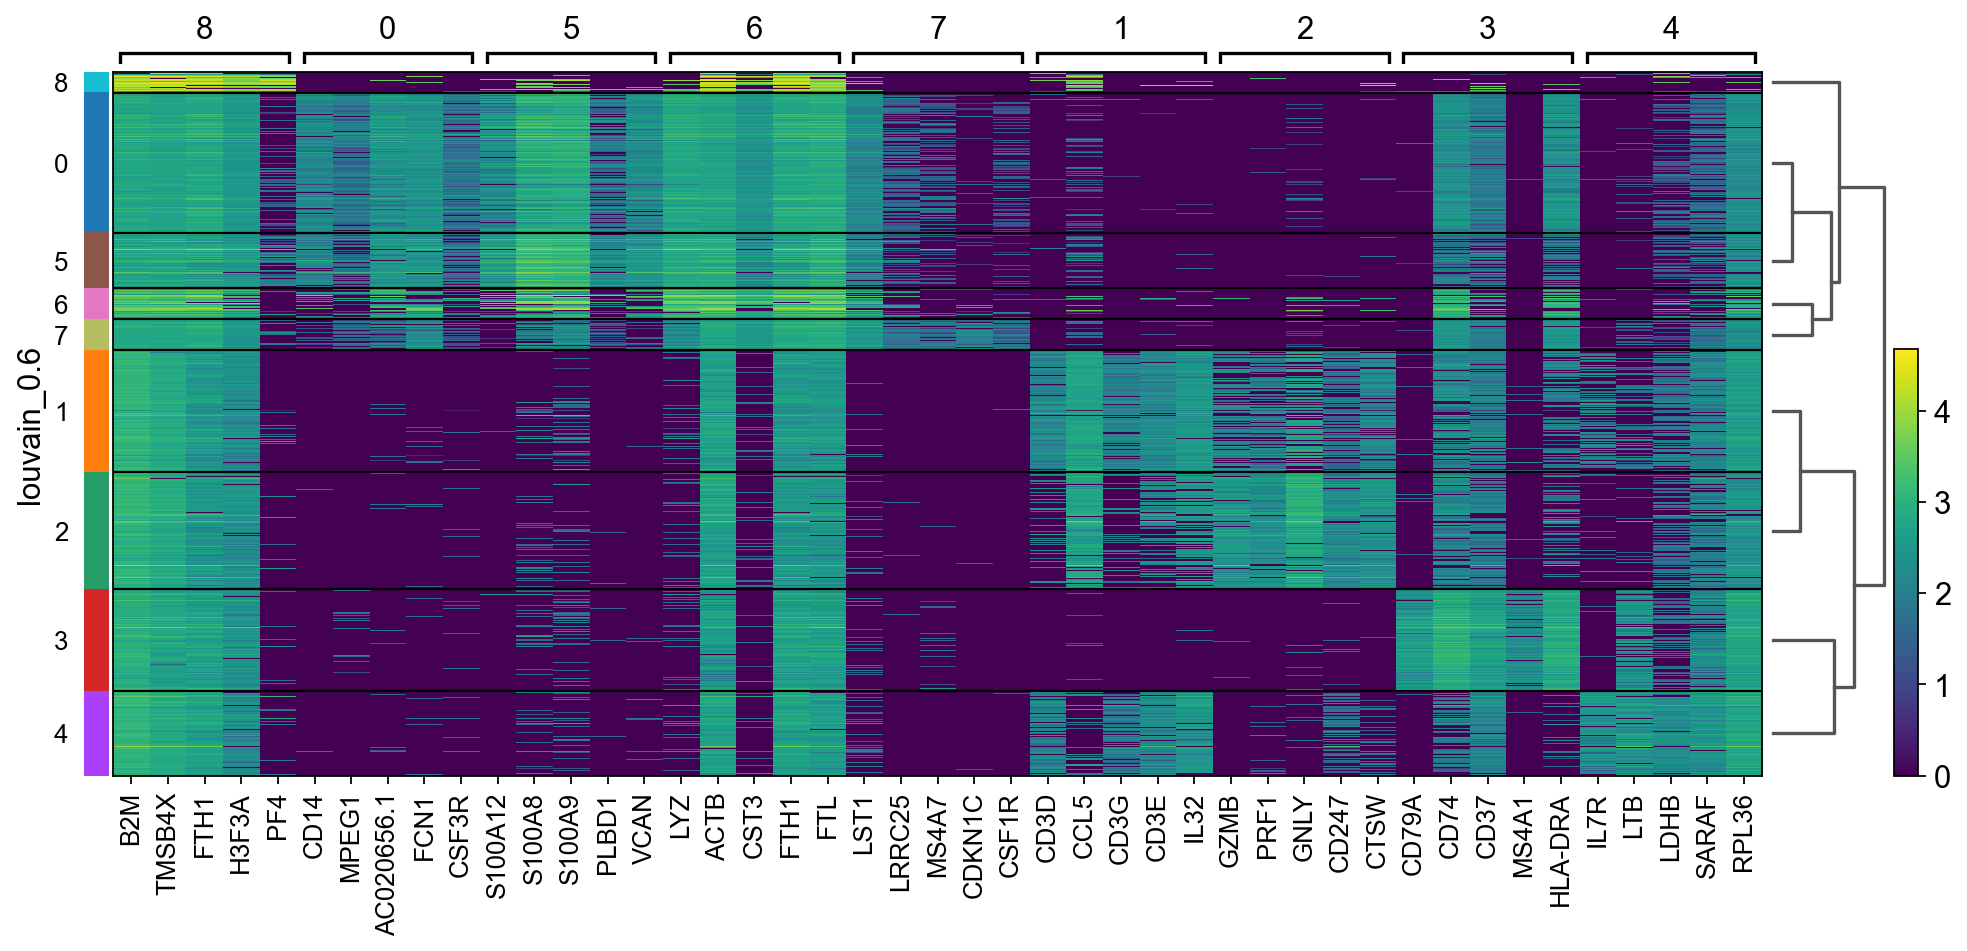

In [19]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6", show_gene_labels=True)


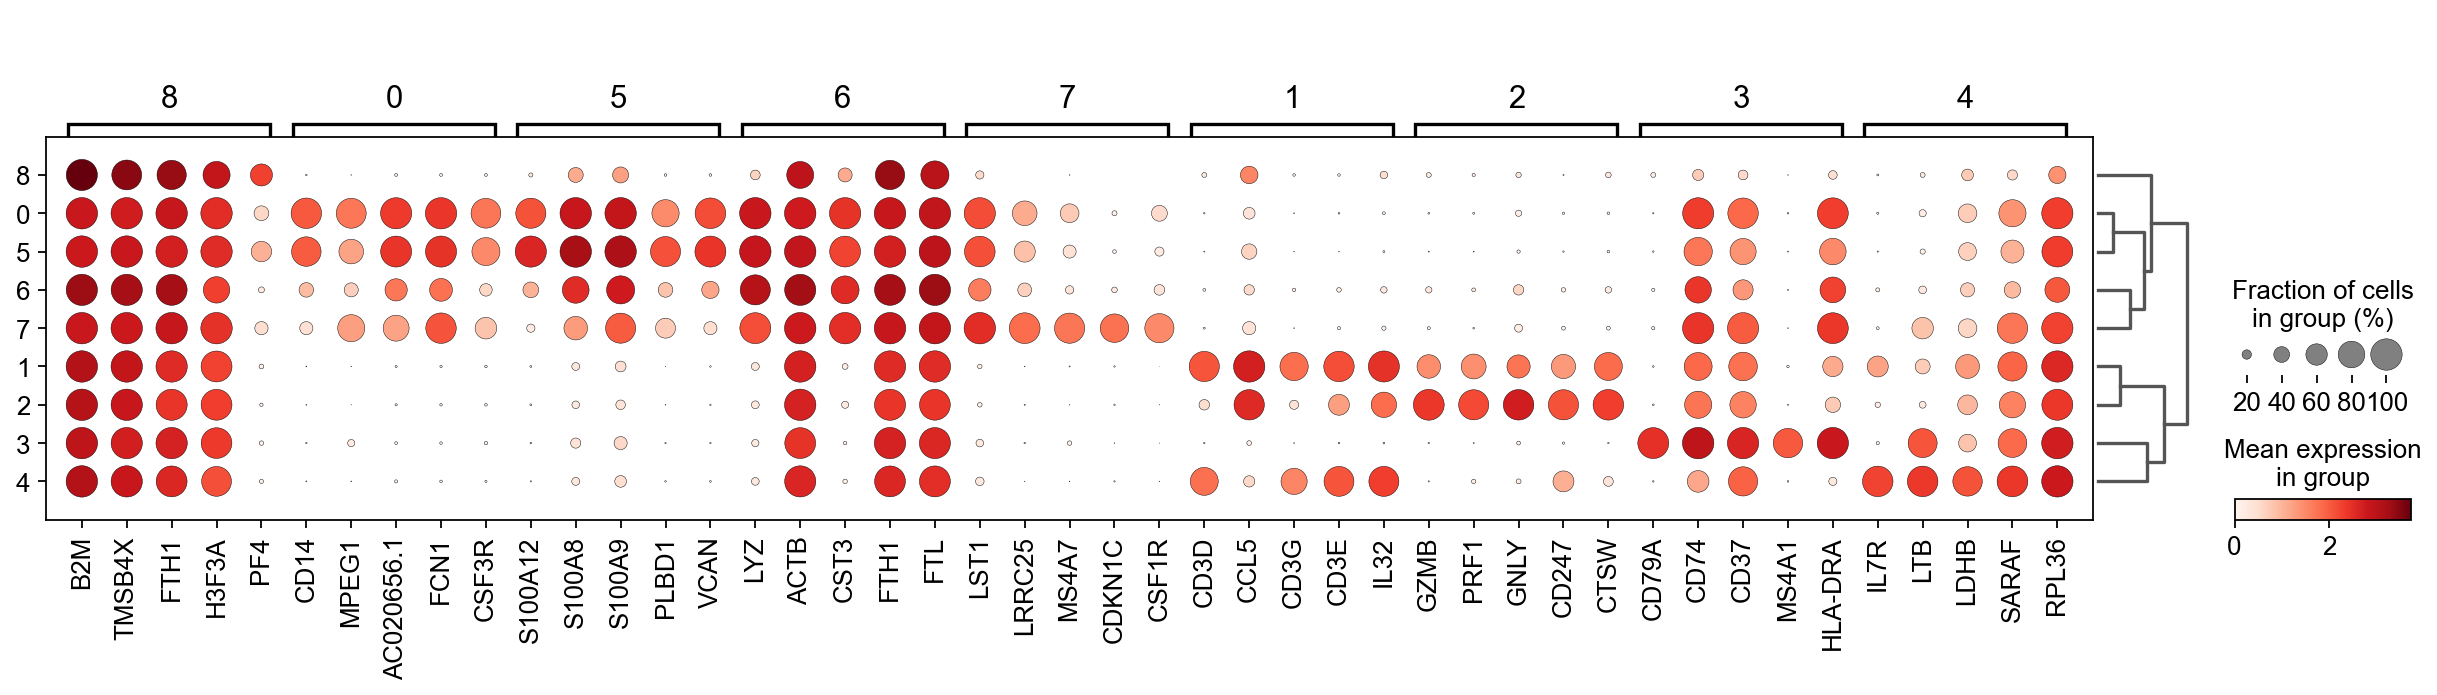

In [20]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

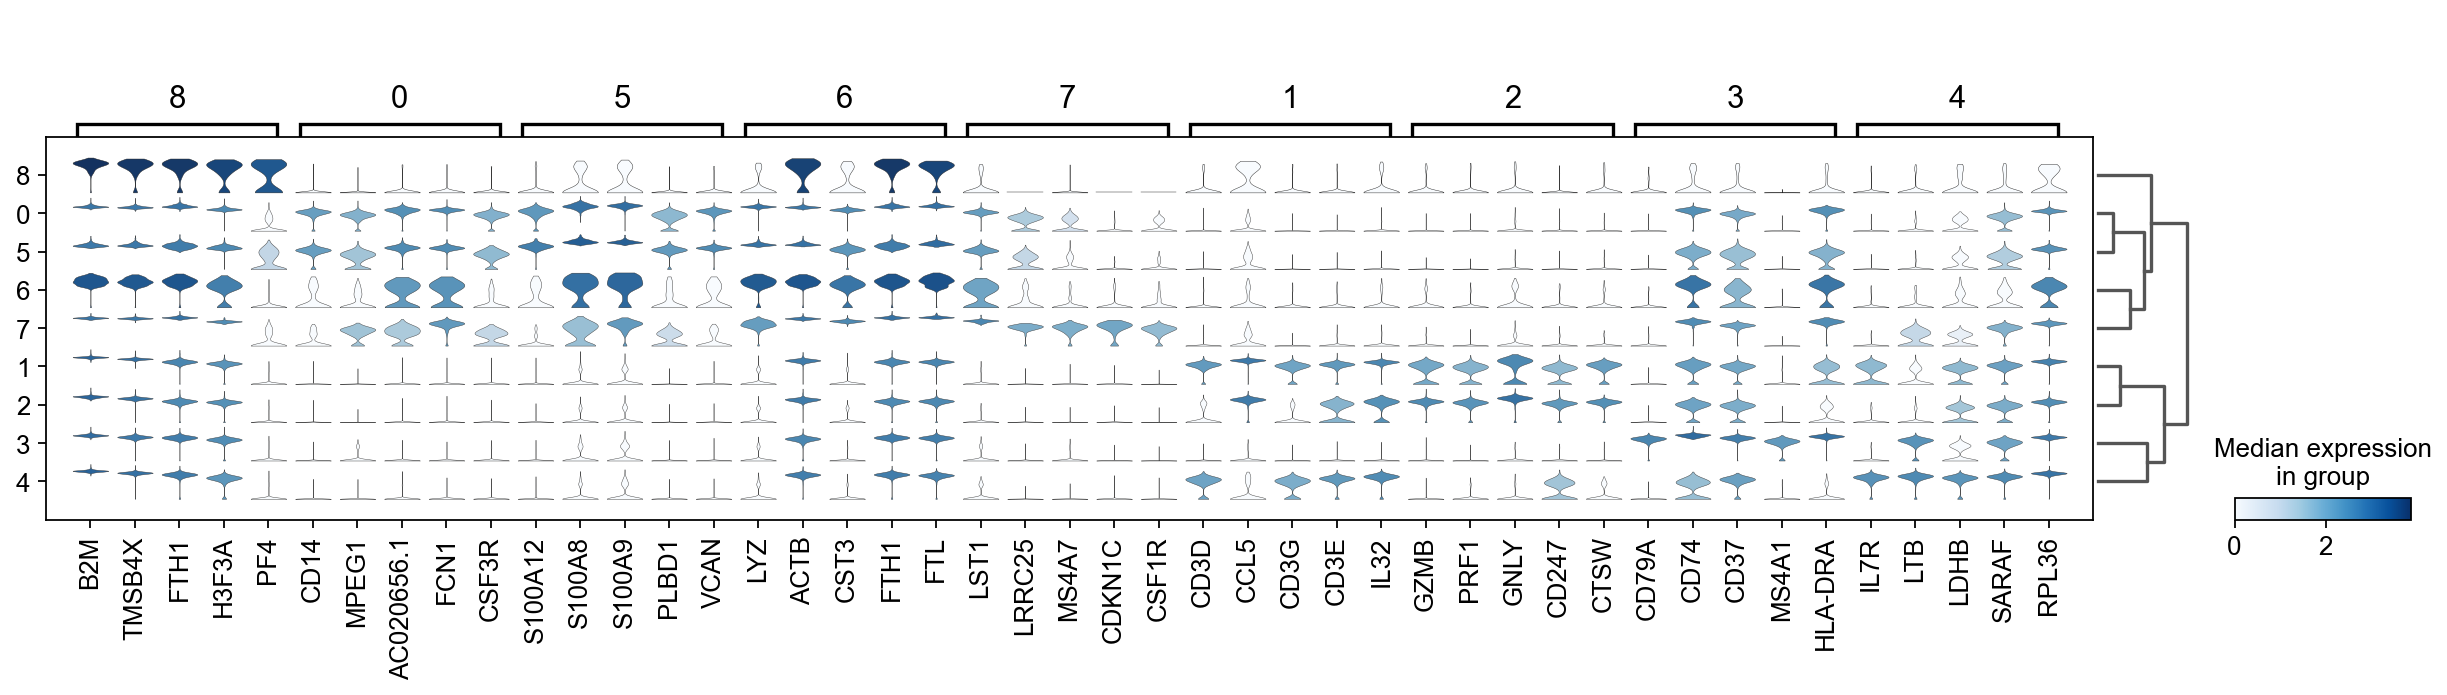

In [21]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

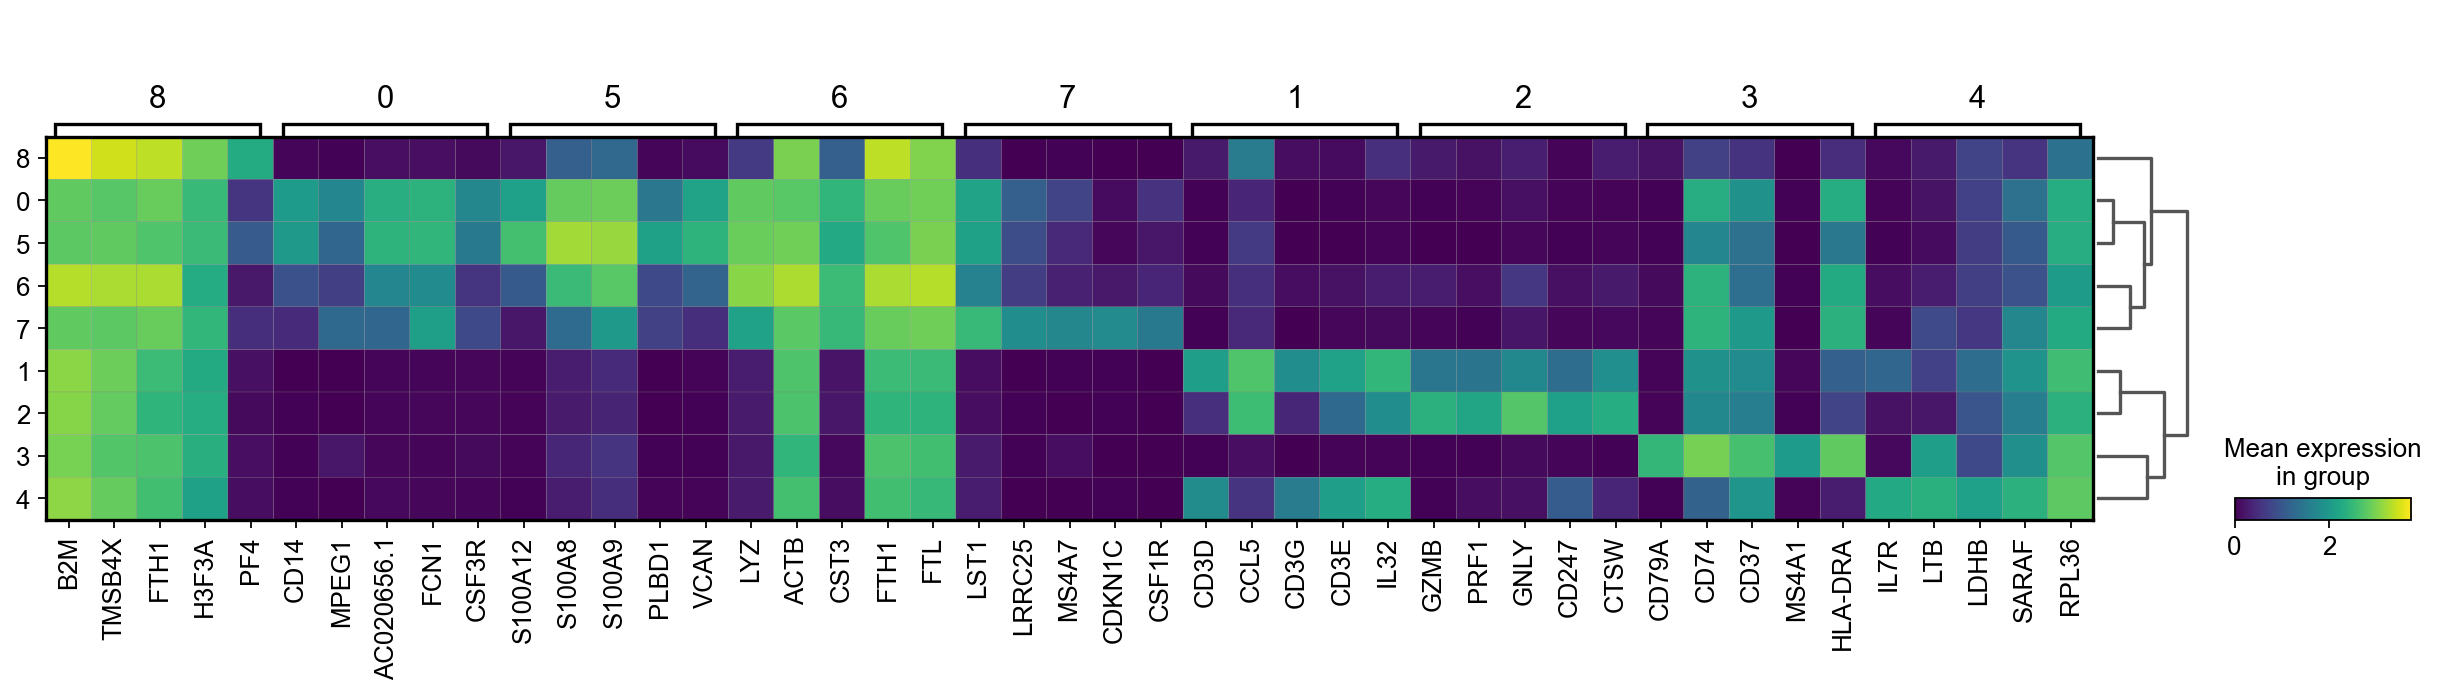

In [22]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

### 7. Compare specific clusters

ranking genes
    finished (0:00:07)


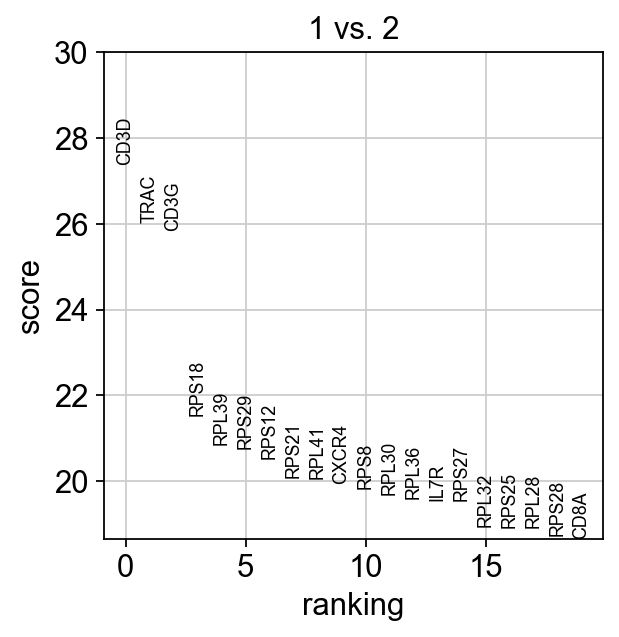

In [23]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

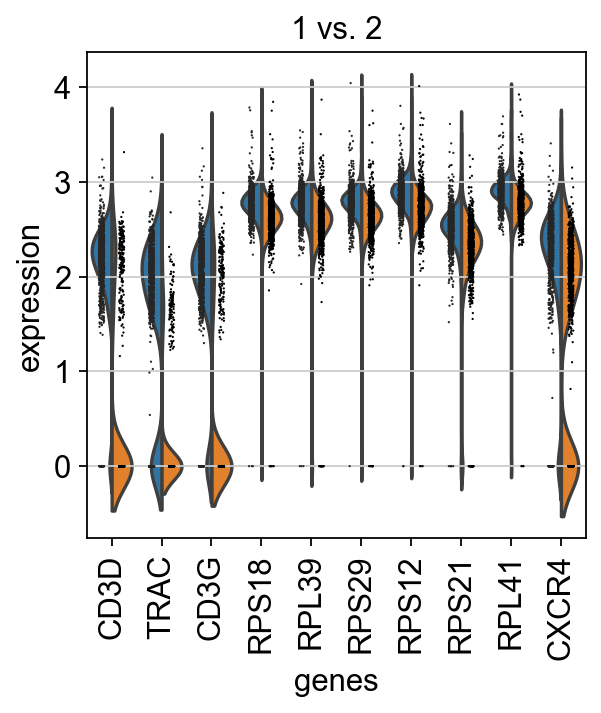

In [24]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

 plot the same genes as violins across all the datasets.

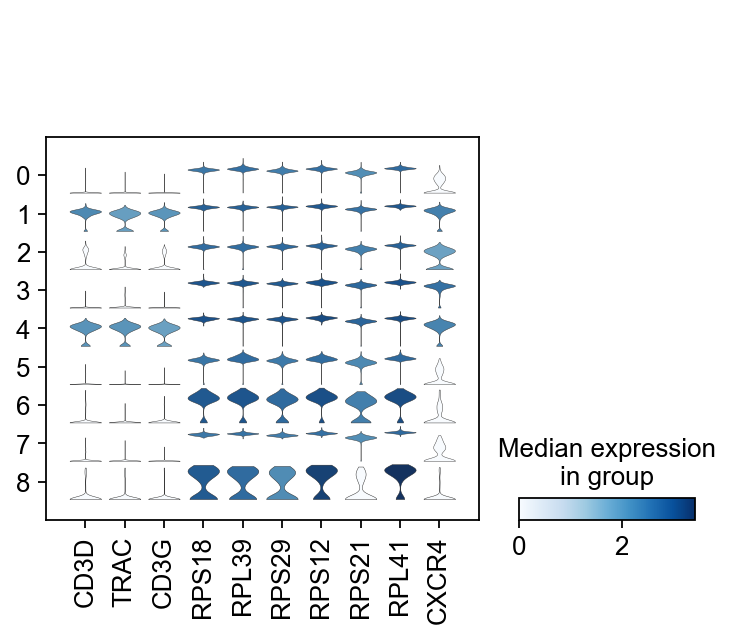

In [25]:


# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'louvain_0.6')

### Differential expression across conditions

In [26]:
cl1 = adata[adata.obs['louvain_0.6'] =='1',:]
cl1.obs['type'].value_counts()

Ctrl     661
Covid    303
Name: type, dtype: int64

ranking genes


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:05)


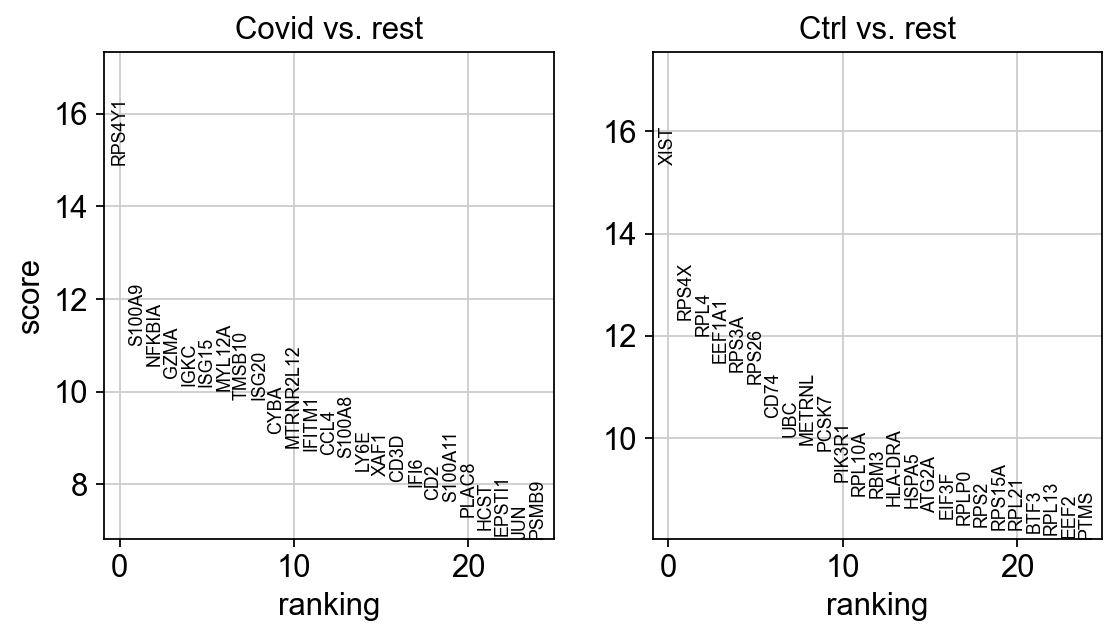

In [27]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key = "wilcoxon")

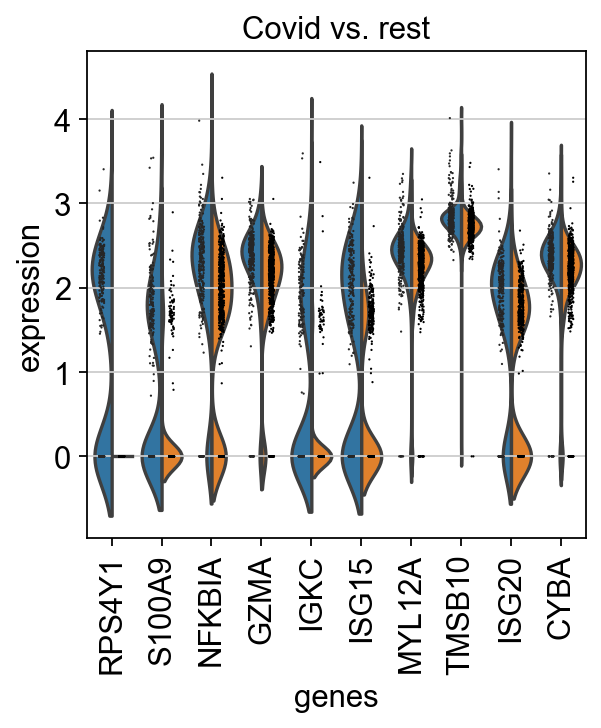

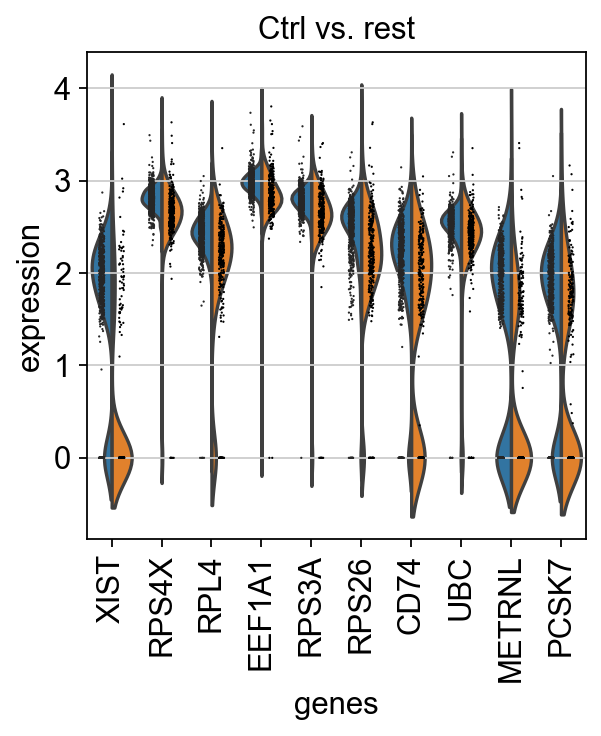

In [28]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")

In [30]:
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['louvain_0.6','type'], use_raw=False)
df2 = df.melt(id_vars=["louvain_0.6",'type'], value_vars=genes)

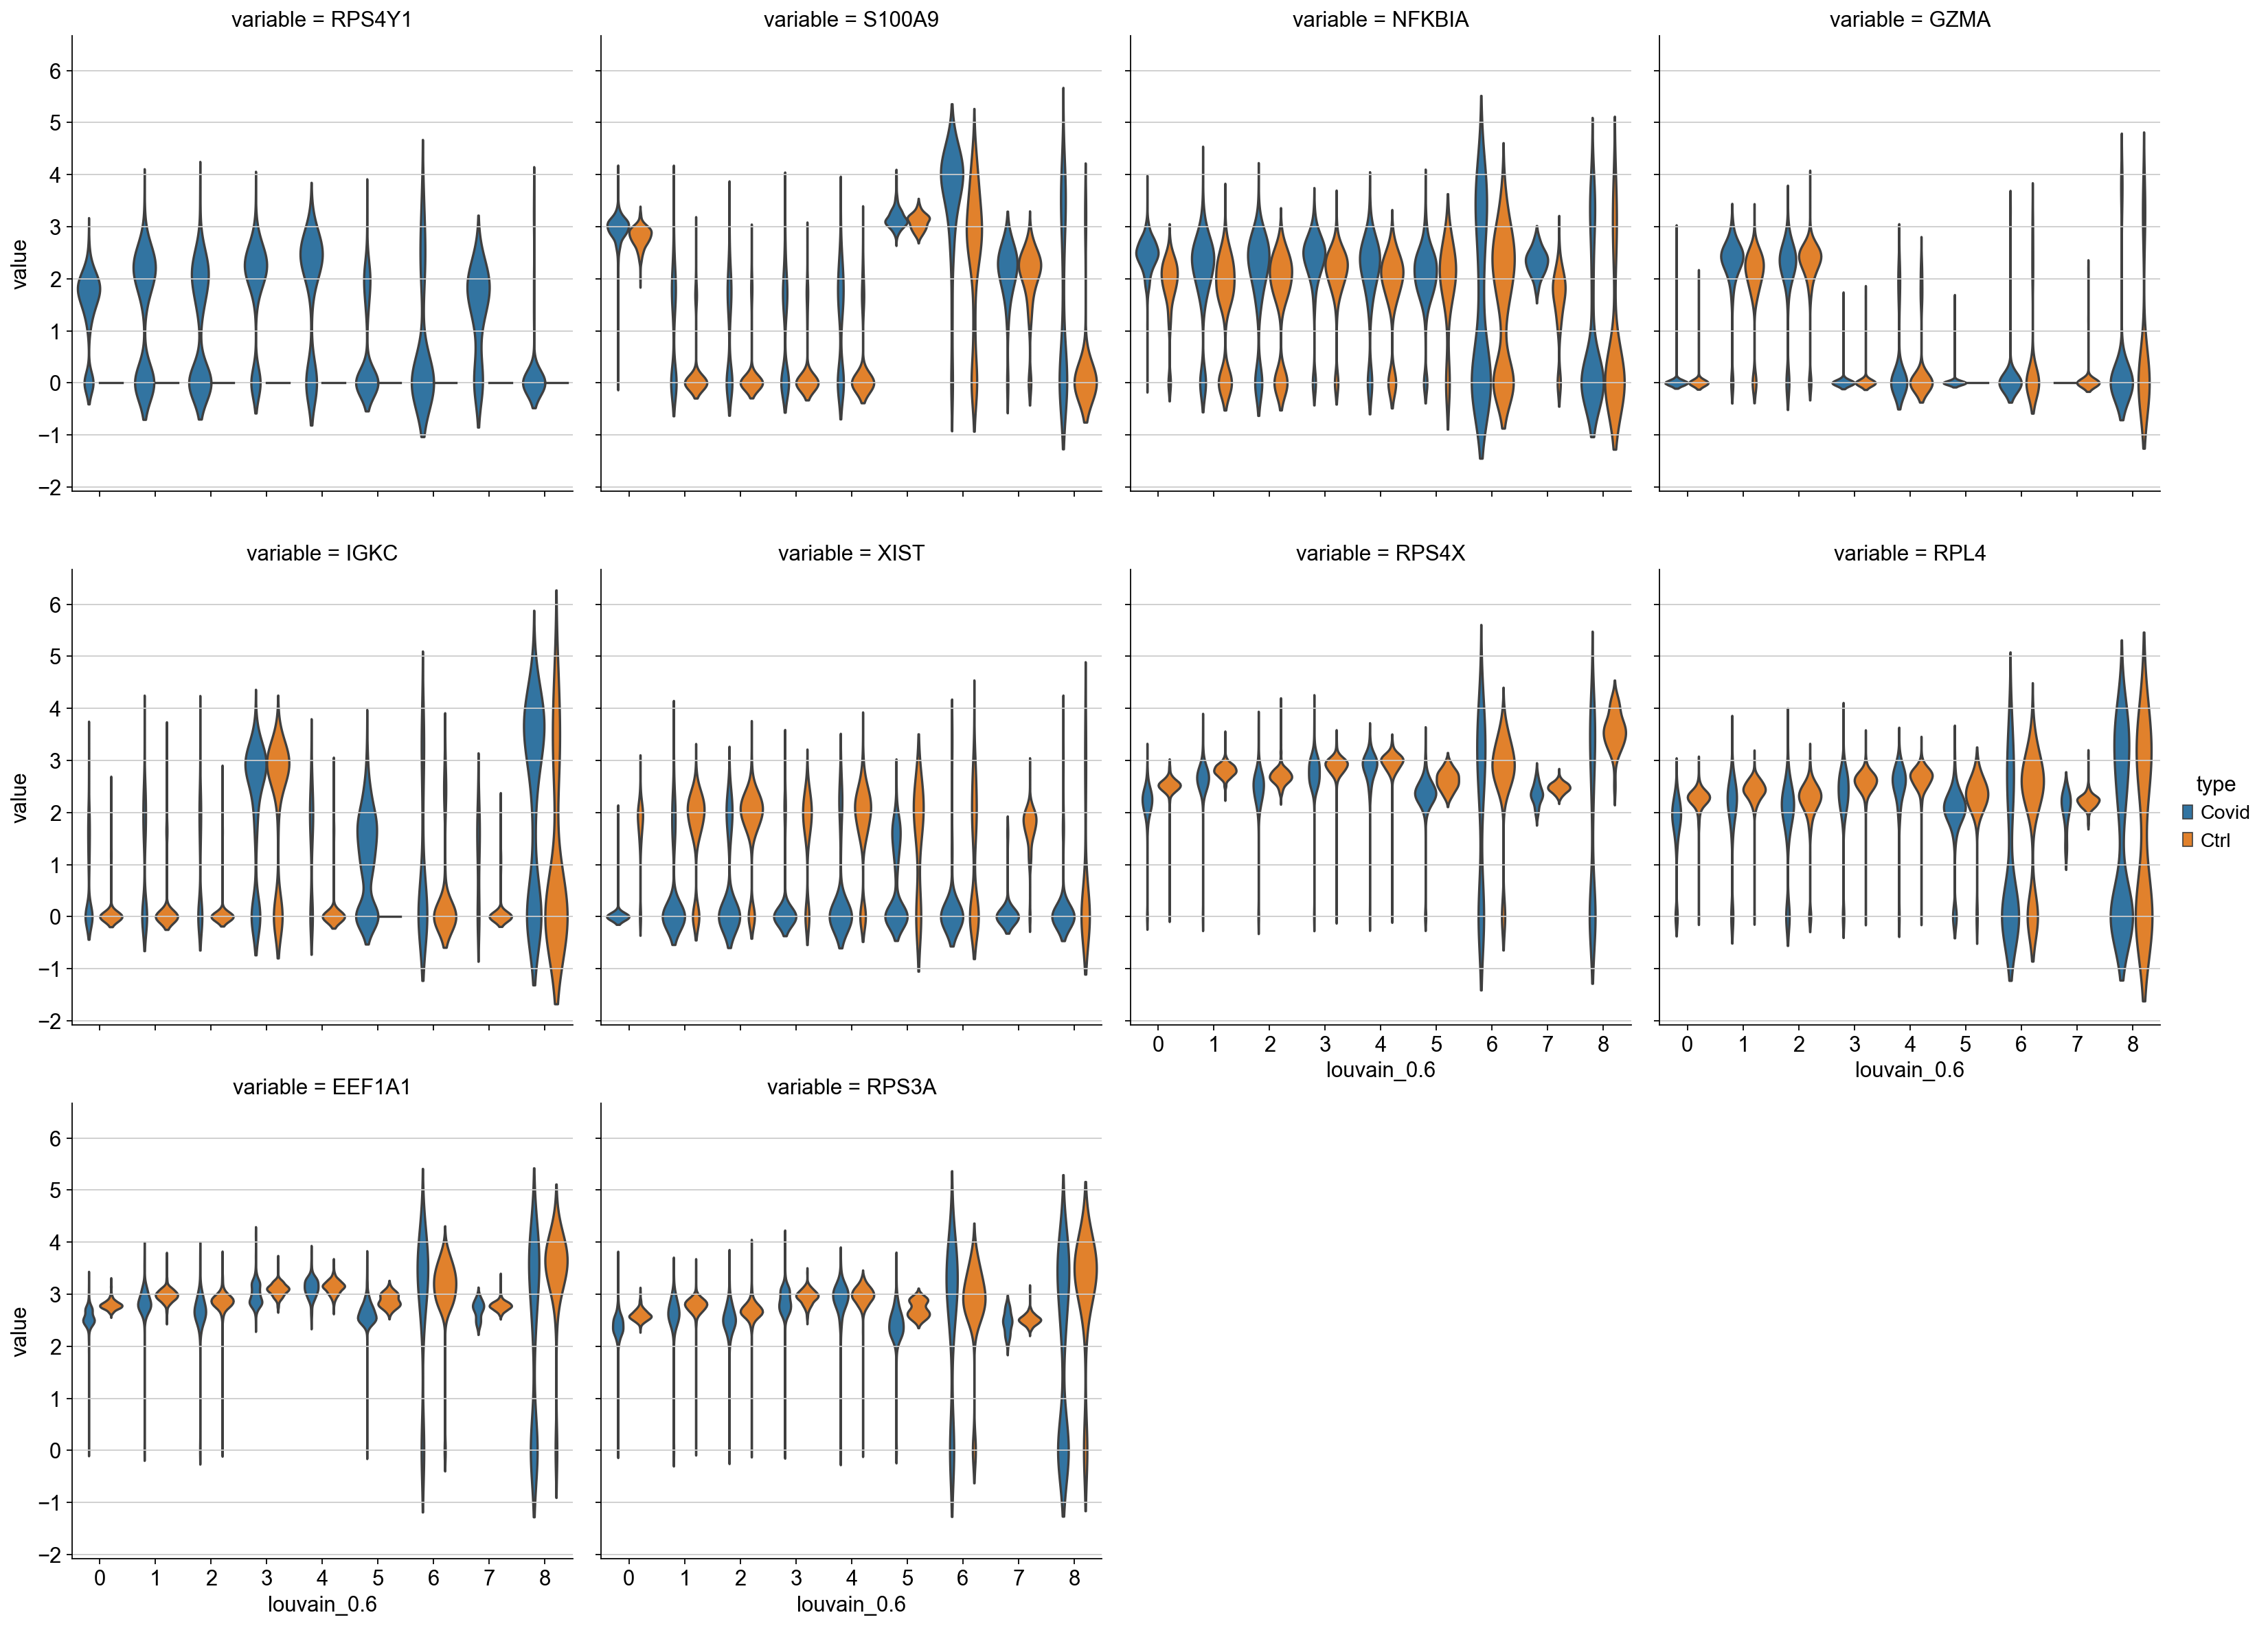

In [31]:
sns.catplot(x = "louvain_0.6", y = "value", hue = "type", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)

### Gene Set Analysis¶

In [32]:
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [33]:
glist = sc.get.rank_genes_groups_df(cl1, group='Covid', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist))

125


In [34]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     description='pathway',
                     cutoff = 0.5)

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\gseapy\enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [35]:
enr_res.results.head()

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0   cytokine-mediated signaling pathway (GO:0019221)  28/633  2.049336e-16   
1  cellular response to type I interferon (GO:007...   12/65  6.304920e-15   
2   type I interferon signaling pathway (GO:0060337)   12/65  6.304920e-15   
3  negative regulation of viral genome replicatio...    8/50  7.999272e-10   
4                     apoptotic process (GO:0006915)  13/231  2.269532e-09   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.340341e-13            0                     0    9.194172   
1      2.400073e-12            0                     0   39.716814   
2      2.400073e-12            0                     0   39.716814   
3      2.283792e-07            0                     0   32.288156   
4      5.183611e-07            0                     0   10.466129   

   Combined Score                                              Genes  
0      332.128862  IFITM1;SP100;IFI6;IFI35;PSMB10;IFIT3;PSMA7;PYC...  
1     1298.638392  BST2;ISG20;IFITM1;SP100;OAS1;MX1;IRF7;IFI6;ISG...  
2     1298.638392  BST2;ISG20;IFITM1;SP100;OAS1;MX1;IRF7;IFI6;ISG...  
3      676.323877      BST2;ISG20;IFITM1;PLSCR1;OAS1;IFI16;MX1;ISG15  
4      208.314606  PLK3;GZMA;MX1;PRF1;GZMB;RTN4;GZMH;CD2;PYCARD;N...

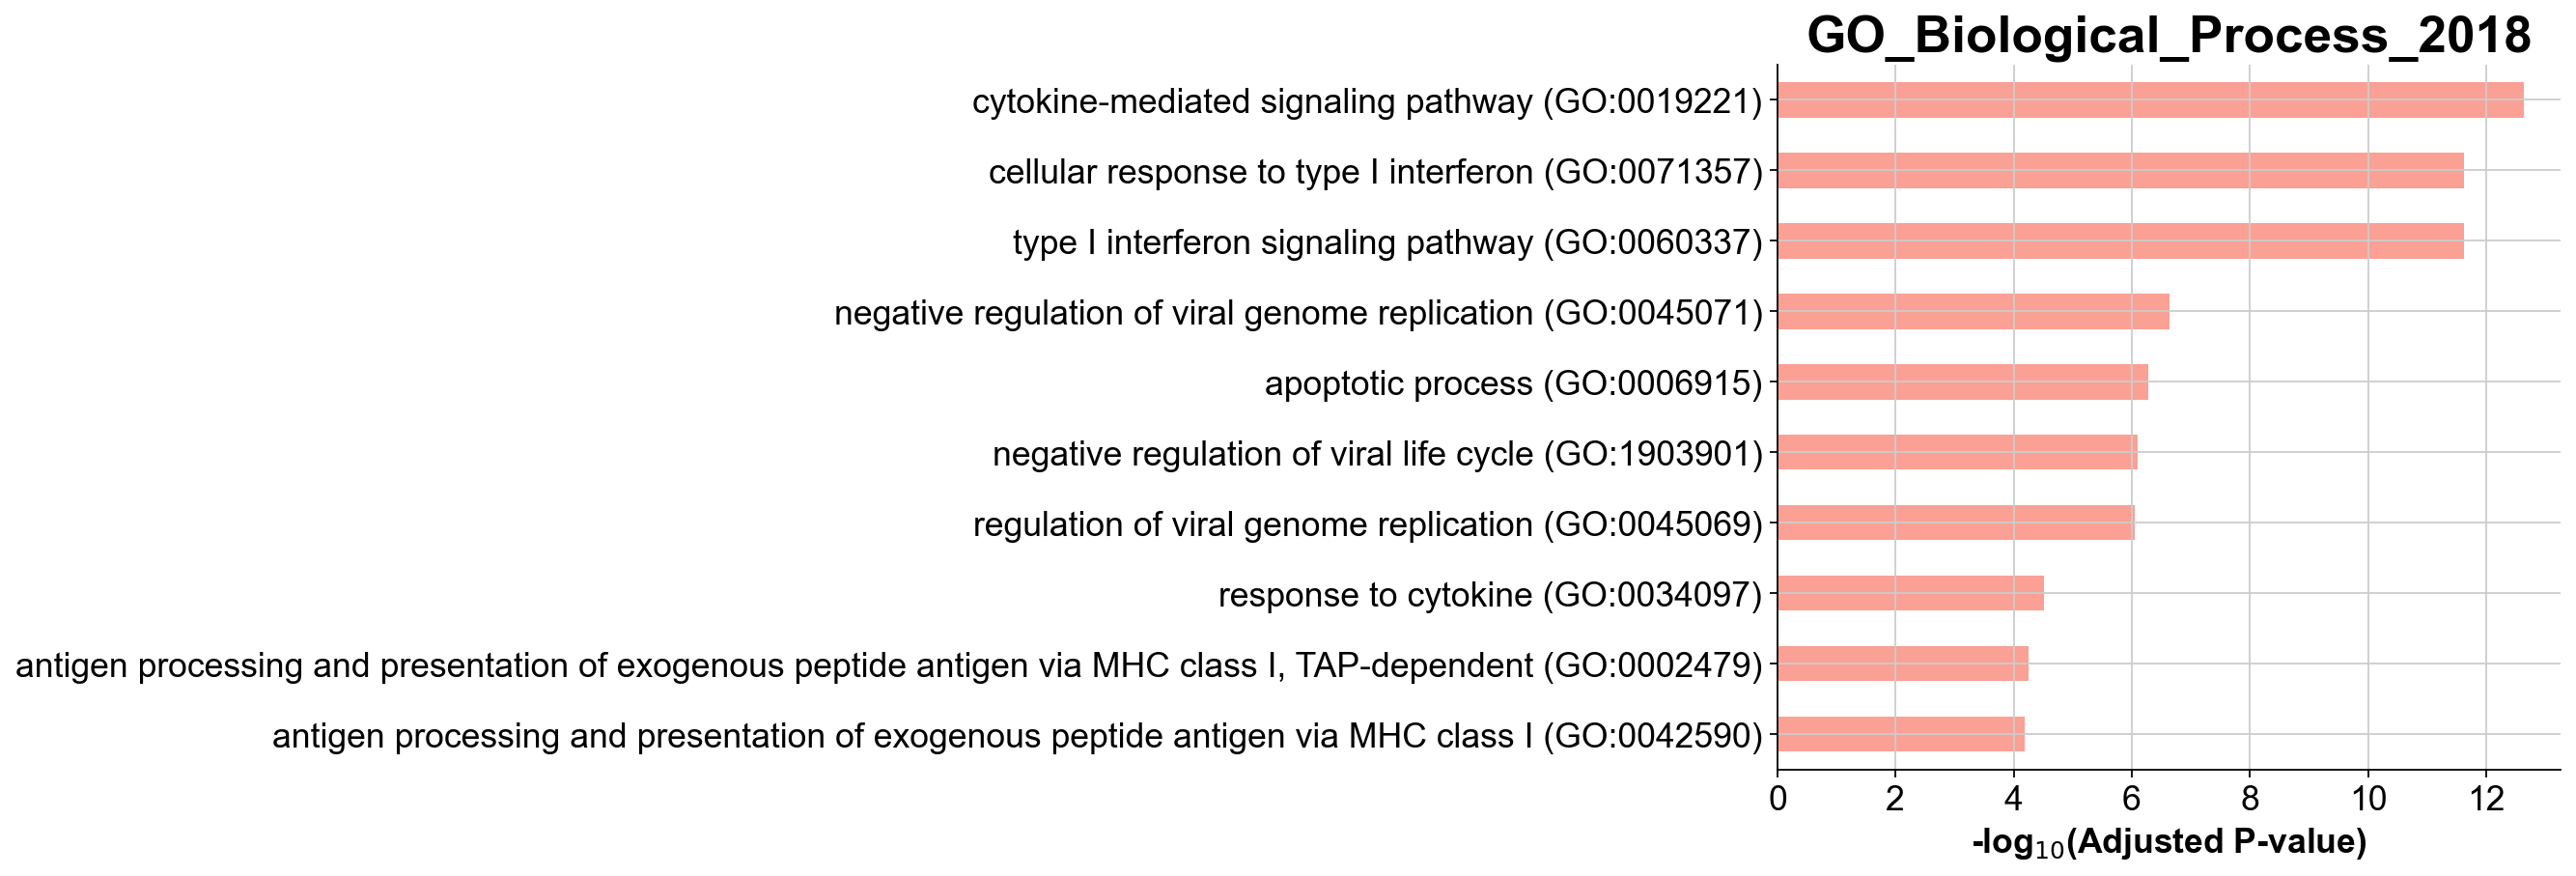

In [36]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

### Gene Set Enrichment Analysis (GSEA)

In [37]:
gene_rank = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [38]:
sc.pp.calculate_qc_metrics(cl1, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(cl1.var_names[cl1.var.n_cells_by_counts>30])]

In [39]:
gene_rank

names  logfoldchanges
0          RPS4Y1       31.339190
27          DDX3Y       29.164715
72         EIF1AY       28.471729
155         CXCL8       28.109119
136        TTTY15       28.100258
...           ...             ...
17069       CD8B2       -2.655957
17930      PHLDA1       -2.766690
18751        XIST       -2.933959
17139       CRIP2       -3.126742
18291  AC004556.1      -27.479694

[8467 rows x 2 columns]

In [40]:
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

In [41]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

MemoryError: Unable to allocate 64.7 MiB for an array with shape (1001, 8467) and data type float64

In [ ]:
terms = res.res2d.index
terms[:20]

In [ ]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])


In [ ]:
adata.write_h5ad('./data/results/scanpy_DGE_covid.h5ad')